In [3]:
## import packages
import pandas as pd
import scorecardpy as sc

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score, roc_curve, classification_report, ConfusionMatrixDisplay, confusion_matrix


from optbinning import BinningProcess
from optbinning.binning.binning_statistics import BinningTable
from optbinning import Scorecard
from optbinning.scorecard import Counterfactual, plot_auc_roc, plot_cap, plot_ks, ScorecardMonitoring


In [4]:
## load data yg sudah ditransform ke woe
path = "../dagster-scorecard/data/outputs/application_selected_features.csv"
df = pd.read_csv(path)
df.set_index("id", inplace=True)

## display
df

,last_pymnt_amnt,out_prncp_inv,dti,months_since_last_pymnt_d_last_credit_pull_d,revol_util,total_rev_hi_lim,months_since_issue_d_last_credit_pull_d,months_since_earliest_cr_line,grade,verification_status,initial_list_status,inq_last_6mths,home_ownership,credit_event
id,,,,,,,,,,,,,,
55320288,354.89,9386.86,25.50,0,44.0,18100,6,225,B,Not Verified,f,1,RENT,0
41930439,422.67,9567.06,36.93,0,81.3,21100,10,179,C,Verified,f,0,MORTGAGE,0
43801439,62.84,1492.56,16.92,0,17.1,25600,10,132,B,Verified,f,0,MORTGAGE,0
598481,197.95,5575.04,25.67,0,41.1,30100,3,311,B,Source Verified,w,1,RENT,0
55847195,312.86,8492.75,34.74,0,20.2,35800,6,129,A,Not Verified,w,2,MORTGAGE,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46446945,543.44,22402.01,27.71,0,79.6,103100,9,340,B,Source Verified,w,0,MORTGAGE,0
60920737,66.71,1859.89,22.45,1,44.7,20900,4,404,C,Not Verified,w,0,MORTGAGE,0
60762054,275.96,7458.56,28.58,0,76.9,4400,4,169,C,Source Verified,f,1,RENT,0


In [5]:
# split ke train-test
train, test = sc.split_df(df, 'credit_event').values()

In [6]:
# woe binning ------
bins = sc.woebin(df, y="credit_event")
# sc.woebin_plot(bins)

[INFO] creating woe binning ...


d:\dagster_projects\credit_scorecard\.venv\lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
d:\dagster_projects\credit_scorecard\.venv\lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
d:\dagster_projects\credit_scorecard\.venv\lib\site-packages\scorecardpy\condition_fun.py:40: UserWarning: Could not infer format, so each element will be parsed

In [7]:
# converting train and test into woe values
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [8]:
y_train = train_woe.loc[:,'credit_event']
X_train = train_woe.loc[:,train_woe.columns != 'credit_event']
y_test = test_woe.loc[:,'credit_event']
X_test = test_woe.loc[:,train_woe.columns != 'credit_event']

In [9]:
# logistic regression ------
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr.fit(X_train, y_train)

LogisticRegression(C=0.9, n_jobs=-1, penalty='l1', solver='saga')

In [10]:
# predicted proability
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

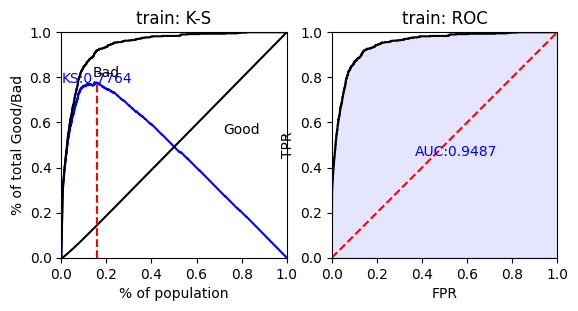

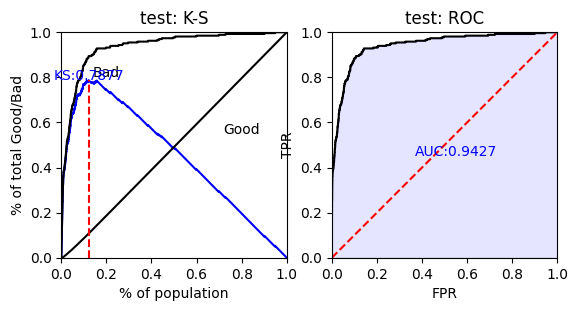

In [11]:
# performance ks & roc ------
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

In [12]:
# score ------
card = sc.scorecard(bins, lr, X_train.columns)
# credit score
train_score = sc.scorecard_ply(train, card, print_step=0)
test_score = sc.scorecard_ply(test, card, print_step=0)

d:\dagster_projects\credit_scorecard\.venv\lib\site-packages\scorecardpy\perf.py:470: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dt_bae = dat.groupby(['ae','bin']).size().reset_index(name='N')\
d:\dagster_projects\credit_scorecard\.venv\lib\site-packages\scorecardpy\perf.py:470: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  dt_bae = dat.groupby(['ae','bin']).size().reset_index(name='N')\
d:\dagster_projects\credit_scorecard\.venv\lib\site-packages\scorecardpy\perf.py:511: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior

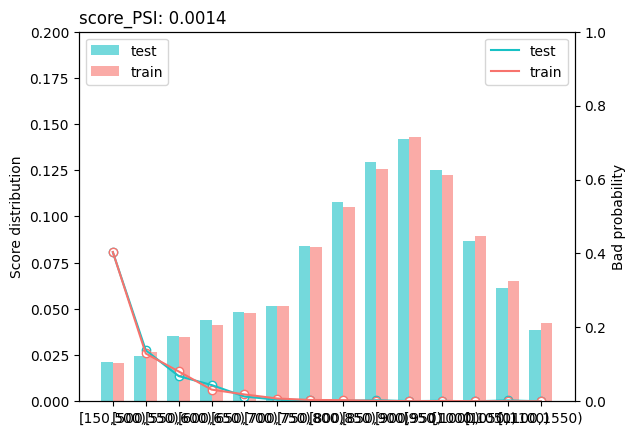

{'psi':   variable       PSI
 0    score  0.001362,
 'pic': {'score': <Figure size 640x480 with 2 Axes>}}

In [13]:
# psi
sc.perf_psi(
  score = {'train':train_score, 'test':test_score},
  label = {'train':y_train, 'test':y_test}
)

In [14]:
## load data yg sudah ditransform ke woe
path = "../dagster-scorecard/data/outputs/application_selected_features.csv"
df = pd.read_csv(path)
df.set_index("id", inplace=True)

## display
df

,last_pymnt_amnt,out_prncp_inv,dti,months_since_last_pymnt_d_last_credit_pull_d,revol_util,total_rev_hi_lim,months_since_issue_d_last_credit_pull_d,months_since_earliest_cr_line,grade,verification_status,initial_list_status,inq_last_6mths,home_ownership,credit_event
id,,,,,,,,,,,,,,
55320288,354.89,9386.86,25.50,0,44.0,18100,6,225,B,Not Verified,f,1,RENT,0
41930439,422.67,9567.06,36.93,0,81.3,21100,10,179,C,Verified,f,0,MORTGAGE,0
43801439,62.84,1492.56,16.92,0,17.1,25600,10,132,B,Verified,f,0,MORTGAGE,0
598481,197.95,5575.04,25.67,0,41.1,30100,3,311,B,Source Verified,w,1,RENT,0
55847195,312.86,8492.75,34.74,0,20.2,35800,6,129,A,Not Verified,w,2,MORTGAGE,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46446945,543.44,22402.01,27.71,0,79.6,103100,9,340,B,Source Verified,w,0,MORTGAGE,0
60920737,66.71,1859.89,22.45,1,44.7,20900,4,404,C,Not Verified,w,0,MORTGAGE,0
60762054,275.96,7458.56,28.58,0,76.9,4400,4,169,C,Source Verified,f,1,RENT,0


In [15]:
def is_dichotomic(column):
            import numpy as np
            unique_values = column.dropna().unique()
            return len(unique_values) == 2 and np.issubdtype(unique_values.dtype, np.integer)

In [16]:
## baseline
feature_names = list(df.copy().drop(labels=["credit_event"], axis=1).columns)
X = df[feature_names]
y = df["credit_event"].values

dichotomic_feats = [col for col in df.columns if col != 'credit_event' and is_dichotomic(df[col])]

In [17]:
binning_process = BinningProcess(feature_names,
                        categorical_variables=dichotomic_feats,
                        )

binning_process.fit(X, y)

BinningProcess(categorical_variables=[],
               variable_names=['last_pymnt_amnt', 'out_prncp_inv', 'dti',
                               'months_since_last_pymnt_d_last_credit_pull_d',
                               'revol_util', 'total_rev_hi_lim',
                               'months_since_issue_d_last_credit_pull_d',
                               'months_since_earliest_cr_line', 'grade',
                               'verification_status', 'initial_list_status',
                               'inq_last_6mths', 'home_ownership'])

In [18]:
transformed_table = binning_process.fit_transform(X, y, metric="woe", check_input=True).reset_index(drop=False)
display(transformed_table.info(),
        transformed_table.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48398 entries, 0 to 48397
Data columns (total 14 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            48398 non-null  int64  
 1   last_pymnt_amnt                               48398 non-null  float64
 2   out_prncp_inv                                 48398 non-null  float64
 3   dti                                           48398 non-null  float64
 4   months_since_last_pymnt_d_last_credit_pull_d  48398 non-null  float64
 5   revol_util                                    48398 non-null  float64
 6   total_rev_hi_lim                              48398 non-null  float64
 7   months_since_issue_d_last_credit_pull_d       48398 non-null  float64
 8   months_since_earliest_cr_line                 48398 non-null  float64
 9   grade                                         48398 non-null 

None

,id,last_pymnt_amnt,out_prncp_inv,dti,months_since_last_pymnt_d_last_credit_pull_d,revol_util,total_rev_hi_lim,months_since_issue_d_last_credit_pull_d,months_since_earliest_cr_line,grade,verification_status,initial_list_status,inq_last_6mths,home_ownership
0,55320288,-3.084728,4.410766,2.569122,2.646885,-0.042404,0.012663,0.171509,0.042596,0.874550,0.493097,-0.383496,-0.175950,-0.255426
1,41930439,6.598767,4.410766,2.569122,2.646885,-1.450568,2.793779,-0.701174,0.515646,0.123803,-0.278428,-0.383496,0.231475,0.216153
2,43801439,6.598767,4.410766,2.569122,2.646885,-0.641732,-0.431539,-0.701174,-0.236391,0.874550,-0.278428,-0.383496,0.231475,0.216153
3,598481,6.598767,4.410766,-1.503758,2.646885,-0.641732,0.361773,2.397215,0.515646,0.874550,-0.038866,0.332549,-0.175950,-0.255426
4,55847195,6.598767,4.410766,2.569122,2.646885,2.591807,0.012663,0.171509,0.515646,1.543149,0.493097,0.332549,-0.483430,0.216153


In [19]:
to_merge = df[["credit_event"]].reset_index(drop=False)
to_merge.drop_duplicates(subset=['id'], keep='last', inplace=True, ignore_index=True)

transformed_applications = pd.merge(transformed_table, to_merge, left_on="id", right_on="id", how="inner") ## <-- merge by id
transformed_applications.drop_duplicates(subset=['id'], keep='last', inplace=True, ignore_index=True)
transformed_applications

,id,last_pymnt_amnt,out_prncp_inv,dti,months_since_last_pymnt_d_last_credit_pull_d,revol_util,total_rev_hi_lim,months_since_issue_d_last_credit_pull_d,months_since_earliest_cr_line,grade,verification_status,initial_list_status,inq_last_6mths,home_ownership,credit_event
0,55320288,-3.084728,4.410766,2.569122,2.646885,-0.042404,0.012663,0.171509,0.042596,0.874550,0.493097,-0.383496,-0.175950,-0.255426,0
1,41930439,6.598767,4.410766,2.569122,2.646885,-1.450568,2.793779,-0.701174,0.515646,0.123803,-0.278428,-0.383496,0.231475,0.216153,0
2,43801439,6.598767,4.410766,2.569122,2.646885,-0.641732,-0.431539,-0.701174,-0.236391,0.874550,-0.278428,-0.383496,0.231475,0.216153,0
3,598481,6.598767,4.410766,-1.503758,2.646885,-0.641732,0.361773,2.397215,0.515646,0.874550,-0.038866,0.332549,-0.175950,-0.255426,0
4,55847195,6.598767,4.410766,2.569122,2.646885,2.591807,0.012663,0.171509,0.515646,1.543149,0.493097,0.332549,-0.483430,0.216153,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48393,46446945,0.342907,4.410766,2.569122,2.646885,2.591807,2.793779,-0.576699,2.380952,0.874550,-0.038866,0.332549,0.231475,0.216153,0
48394,60920737,6.598767,4.410766,2.569122,-1.339139,-0.042404,0.012663,1.234863,2.380952,0.123803,0.493097,0.332549,0.231475,0.216153,0
48395,60762054,6.598767,4.410766,-1.184089,2.646885,2.591807,-0.236035,1.234863,-0.236391,0.123803,-0.038866,-0.383496,-0.175950,-0.255426,0
48396,59679287,6.598767,4.410766,2.569122,2.646885,-0.910211,0.361773,2.397215,2.380952,0.123803,-0.038866,0.332549,-0.483430,0.216153,0


training logistic regression

In [29]:
## load data yg sudah ditransform ke woe
path = "../dagster-scorecard/data/outputs/application_selected_features.csv"
df = pd.read_csv(path)
df.set_index("id", inplace=True)

## display
df

,last_pymnt_amnt,out_prncp_inv,dti,months_since_last_pymnt_d_last_credit_pull_d,revol_util,total_rev_hi_lim,months_since_issue_d_last_credit_pull_d,months_since_earliest_cr_line,grade,verification_status,initial_list_status,inq_last_6mths,home_ownership,credit_event
id,,,,,,,,,,,,,,
55320288,354.89,9386.86,25.50,0,44.0,18100,6,225,B,Not Verified,f,1,RENT,0
41930439,422.67,9567.06,36.93,0,81.3,21100,10,179,C,Verified,f,0,MORTGAGE,0
43801439,62.84,1492.56,16.92,0,17.1,25600,10,132,B,Verified,f,0,MORTGAGE,0
598481,197.95,5575.04,25.67,0,41.1,30100,3,311,B,Source Verified,w,1,RENT,0
55847195,312.86,8492.75,34.74,0,20.2,35800,6,129,A,Not Verified,w,2,MORTGAGE,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46446945,543.44,22402.01,27.71,0,79.6,103100,9,340,B,Source Verified,w,0,MORTGAGE,0
60920737,66.71,1859.89,22.45,1,44.7,20900,4,404,C,Not Verified,w,0,MORTGAGE,0
60762054,275.96,7458.56,28.58,0,76.9,4400,4,169,C,Source Verified,f,1,RENT,0


In [30]:
def is_dichotomic(column):
            import numpy as np
            unique_values = column.dropna().unique()
            return len(unique_values) == 2 and np.issubdtype(unique_values.dtype, np.integer)

In [31]:
## baseline
feature_names = list(df.copy().drop(labels=["credit_event"], axis=1).columns)
X = df[feature_names]
y = df["credit_event"].values

dichotomic_feats = [col for col in df.columns if col != 'credit_event' and is_dichotomic(df[col])]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (33878, 13)
X_test:  (14520, 13)
y_train:  (33878,)
y_test:  (14520,)


In [33]:
estimator = LogisticRegression(solver="lbfgs", random_state=888)

binning_process = BinningProcess(feature_names,
                        categorical_variables=dichotomic_feats,
                        )

scorecard = Scorecard(binning_process=binning_process,
                      estimator=estimator, scaling_method="min_max",
                      scaling_method_params={"min": 300, "max": 850})

param_grid = {
    "estimator__C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

scorecard_search = GridSearchCV(
    estimator=scorecard,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1
)

# model fitting
scorecard.fit(X_train, y_train)

Scorecard(binning_process=BinningProcess(categorical_variables=[],
                                         variable_names=['last_pymnt_amnt',
                                                         'out_prncp_inv', 'dti',
                                                         'months_since_last_pymnt_d_last_credit_pull_d',
                                                         'revol_util',
                                                         'total_rev_hi_lim',
                                                         'months_since_issue_d_last_credit_pull_d',
                                                         'months_since_earliest_cr_line',
                                                         'grade',
                                                         'verification_status',
                                                         'initial_list_status',
                                                         'inq_last_6mths',
                                                         'home_ownership']),
          estimator=LogisticRegression(random_state=888),
          scaling_method='min_max',
          scaling_method_params={'max': 850, 'min': 300})

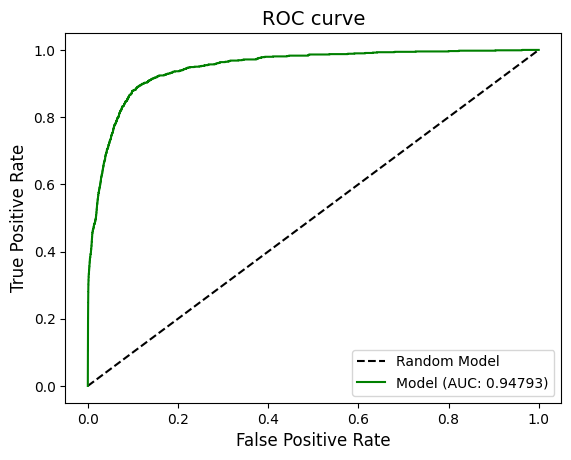

In [37]:
y_pred = scorecard.predict_proba(X)[:, 1]
plot_auc_roc(y, y_pred)

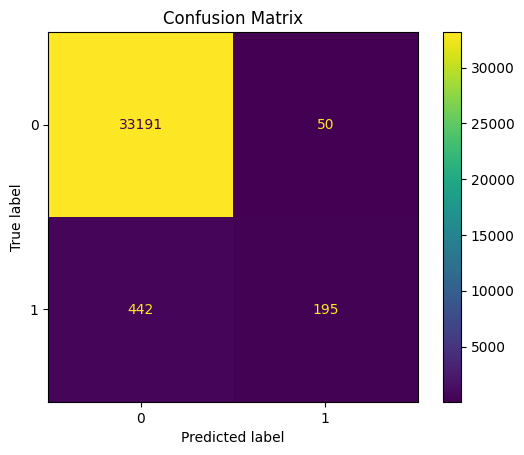

In [36]:
import matplotlib.pyplot as plt
y_pred = scorecard.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

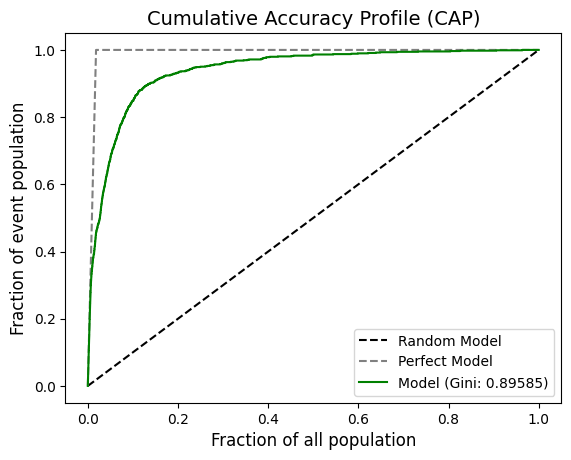

In [38]:
plot_cap(y, y_pred)

In [28]:
plot_ks(y, y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [48398, 33878]

In [11]:
variable_names = list(transformed_applications.columns[1:-1]) # exclude id dan credit event
X = transformed_applications[variable_names]
y = transformed_applications["credit_event"].values

print("y shape: ", y.shape)
print("X shape:", X.shape)

y shape:  (20403,)
X shape: (20403, 21)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (14282, 21)
X_test:  (6121, 21)
y_train:  (14282,)
y_test:  (6121,)


In [13]:
estimator = LogisticRegression(random_state=777)

scorecard = Scorecard(estimator=estimator, scaling_method="min_max",
                      scaling_method_params={"min": 300, "max": 850})

param_grid = {
    "estimator__C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

scorecard_search = GridSearchCV(
    estimator=scorecard,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1
)

# model fitting
scorecard.fit(X_train, y_train)

TypeError: Scorecard.__init__() missing 1 required positional argument: 'binning_process'

In [4]:
## baseline
feature_names = list(df.columns[:-1]) ## <-- exclude credit event
X = df[feature_names]
y = df["credit_event"].values

dichotomic_feats = [col for col in df.columns if col != 'credit_event' and is_dichotomic(df[col])]

In [5]:
binning_process = BinningProcess(feature_names,
                        categorical_variables=dichotomic_feats,
                        )

binning_process.fit(X, y)

BinningProcess(categorical_variables=['reg_city_not_work_city',
                                      'flag_document_3'],
               variable_names=['amt_annuity', 'amt_goods_price',
                               'name_income_type', 'name_education_type',
                               'region_population_relative', 'days_employed',
                               'days_registration', 'days_id_publish',
                               'own_car_age', 'occupation_type',
                               'region_rating_client_w_city',
                               'reg_city_not_work_city', 'organiza...
                               'ext_source_1', 'ext_source_2', 'ext_source_3',
                               'basementarea_avg', 'floorsmax_avg',
                               'livingarea_avg', 'years_beginexpluatation_medi',
                               'entrances_medi', 'days_last_phone_change',
                               'flag_document_3', 'sk_id_prev_count',
                               'sk_dpd_def_max', 'amt_credit_sum_debt_sum',
                               'amt_credit_sum_limit_sum',
                               'amt_balance_avg_avg',
                               'amt_drawings_atm_current_avg_avg',
                               'amt_drawings_current_avg_avg', ...])

In [6]:
summary_table = binning_process.summary()
summary_table.sort_values(by="iv", ascending=False, inplace=True)
summary_table

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
15,ext_source_3,numerical,OPTIMAL,True,8,0.390321,0.046865,0.337034,0.186009
14,ext_source_2,numerical,OPTIMAL,True,12,0.385185,0.046129,0.337008,0.01774
13,ext_source_1,numerical,OPTIMAL,True,7,0.146107,0.017747,0.178425,0.056694
5,days_employed,numerical,OPTIMAL,True,10,0.133588,0.016535,0.204866,0.042012
1,amt_goods_price,numerical,OPTIMAL,True,10,0.109045,0.013428,0.170015,0.028812
9,occupation_type,categorical,OPTIMAL,True,6,0.102416,0.0127,0.174921,0.077157
12,organization_type,categorical,OPTIMAL,True,9,0.091564,0.011342,0.166141,0.0025
21,days_last_phone_change,numerical,OPTIMAL,True,10,0.078249,0.00968,0.151703,0.000424
3,name_education_type,categorical,OPTIMAL,True,2,0.074643,0.009237,0.109113,0.152773
37,prev_amt_down_payment_sum,numerical,OPTIMAL,True,6,0.073074,0.009036,0.137666,0.037161


In [7]:
transformed_table = binning_process.fit_transform(X, y, metric="woe", check_input=True).reset_index(drop=False)
display(transformed_table.info(),
        transformed_table.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20403 entries, 0 to 20402
Data columns (total 43 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    20403 non-null  int64  
 1   amt_annuity                           20403 non-null  float64
 2   amt_goods_price                       20403 non-null  float64
 3   name_income_type                      20403 non-null  float64
 4   name_education_type                   20403 non-null  float64
 5   region_population_relative            20403 non-null  float64
 6   days_employed                         20403 non-null  float64
 7   days_registration                     20403 non-null  float64
 8   days_id_publish                       20403 non-null  float64
 9   own_car_age                           20403 non-null  float64
 10  occupation_type                       20403 non-null  float64
 11  region_rating_c

None

,id,amt_annuity,amt_goods_price,name_income_type,name_education_type,region_population_relative,days_employed,days_registration,days_id_publish,own_car_age,...,cnt_instalment_mature_cum_avg_avg,installment_paiement_delay_min_min,amount_instalment_difference_max_max,amount_instalment_difference_avg_avg,prev_amt_application_sum,prev_amt_down_payment_sum,prev_rate_down_payment_avg,prev_days_decision_avg,prev_days_first_drawing_avg,prev_days_first_due_avg
0,112408,0.040408,-0.735818,-0.203154,-0.137383,-0.100319,1.869262,2.236888,7.086683,0.374246,...,0.000000,0.068453,0.619553,-0.017133,5.928705,4.731419,4.857691,3.705366,-0.020351,3.033621
1,453795,5.327344,-0.735818,0.217638,0.546711,-0.259509,-1.548379,2.236888,-0.956417,0.802949,...,0.000000,0.151157,0.619553,-0.017133,5.928705,4.731419,4.857691,3.705366,-0.020351,3.033621
2,342026,5.327344,0.202023,-0.203154,-0.137383,0.062278,-0.732147,2.236888,7.086683,0.000000,...,0.000000,0.384738,0.619553,-0.017133,5.928705,-0.138222,-0.131742,3.705366,-0.020351,3.033621
3,329085,5.327344,-0.735818,-0.203154,-0.137383,-0.185462,1.869262,-2.905874,7.086683,0.000000,...,0.166779,-0.233440,0.619553,-0.017133,5.928705,-0.138222,-0.131742,3.705366,-0.020351,3.033621
4,285854,5.327344,0.000690,-0.203154,-0.137383,-0.604417,1.869262,2.236888,-0.956417,0.186539,...,0.000000,0.151157,0.619553,-0.017133,5.928705,4.731419,4.857691,3.705366,-0.020351,-0.747453


In [8]:
to_merge = df[["credit_event"]].reset_index(drop=False)
to_merge.drop_duplicates(subset=['id'], keep='last', inplace=True, ignore_index=True)
display(to_merge.head(),
        to_merge.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20403 entries, 0 to 20402
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   id            20403 non-null  int64
 1   credit_event  20403 non-null  int64
dtypes: int64(2)
memory usage: 318.9 KB


,id,credit_event
0,112408,0
1,453795,0
2,342026,0
3,329085,0
4,285854,0


None

In [9]:
transformed_applications = pd.merge(transformed_table, to_merge, left_on="id", right_on="id", how="inner") ## <-- merge by id
transformed_applications.drop_duplicates(subset=['id'], keep='last', inplace=True, ignore_index=True)
transformed_applications

,id,amt_annuity,amt_goods_price,name_income_type,name_education_type,region_population_relative,days_employed,days_registration,days_id_publish,own_car_age,...,installment_paiement_delay_min_min,amount_instalment_difference_max_max,amount_instalment_difference_avg_avg,prev_amt_application_sum,prev_amt_down_payment_sum,prev_rate_down_payment_avg,prev_days_decision_avg,prev_days_first_drawing_avg,prev_days_first_due_avg,credit_event
0,112408,0.040408,-0.735818,-0.203154,-0.137383,-0.100319,1.869262,2.236888,7.086683,0.374246,...,0.068453,0.619553,-0.017133,5.928705,4.731419,4.857691,3.705366,-0.020351,3.033621,0
1,453795,5.327344,-0.735818,0.217638,0.546711,-0.259509,-1.548379,2.236888,-0.956417,0.802949,...,0.151157,0.619553,-0.017133,5.928705,4.731419,4.857691,3.705366,-0.020351,3.033621,0
2,342026,5.327344,0.202023,-0.203154,-0.137383,0.062278,-0.732147,2.236888,7.086683,0.000000,...,0.384738,0.619553,-0.017133,5.928705,-0.138222,-0.131742,3.705366,-0.020351,3.033621,0
3,329085,5.327344,-0.735818,-0.203154,-0.137383,-0.185462,1.869262,-2.905874,7.086683,0.000000,...,-0.233440,0.619553,-0.017133,5.928705,-0.138222,-0.131742,3.705366,-0.020351,3.033621,0
4,285854,5.327344,0.000690,-0.203154,-0.137383,-0.604417,1.869262,2.236888,-0.956417,0.186539,...,0.151157,0.619553,-0.017133,5.928705,4.731419,4.857691,3.705366,-0.020351,-0.747453,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20398,388432,0.704616,0.416693,0.140388,-0.137383,-0.033409,1.869262,2.236888,-0.092369,0.080535,...,0.068453,0.619553,-0.017133,5.928705,4.731419,4.857691,3.705366,-0.020351,3.033621,0
20399,266796,0.040408,-0.274976,-0.203154,-0.137383,0.581192,-0.303880,-1.744756,-1.487626,0.000000,...,0.151157,-3.387684,-0.017133,-4.948167,-0.138222,-0.131742,-1.525538,-0.020351,-0.747453,1
20400,425507,-1.482871,0.668578,-0.203154,-0.137383,-0.604417,1.869262,2.236888,7.086683,0.000000,...,0.384738,0.619553,-0.017133,5.928705,-0.138222,-0.131742,-1.525538,-0.020351,-0.747453,0
20401,312250,-0.871145,0.899802,0.463904,0.546711,-0.100319,1.869262,2.236888,7.086683,0.186539,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_auc_score, roc_curve, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import chi2, SelectFromModel

In [11]:
variable_names = list(transformed_applications.columns[1:-1])  ## exclude id and credit event
X = transformed_applications[variable_names]
y = transformed_applications["credit_event"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

In [12]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

In [13]:
rf = RandomForestClassifier(random_state=777)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=10, cv=3, verbose=2, random_state=777, n_jobs=-1)

In [14]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


d:\dagster_projects\credit_scorecard\.venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
9 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "d:\dagster_projects\credit_scorecard\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\dagster_projects\credit_scorecard\.venv\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "d:\dagster_projects\credit_scorecard\.venv\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_para

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=777),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200, 300, 400]},
                   random_state=777, verbose=2)

In [15]:
# log each set of parameters and their corresponding scores
for i in range(len(rf_random.cv_results_['params'])):
    params = rf_random.cv_results_['params'][i]
    score = rf_random.cv_results_['mean_test_score'][i]
    print(f"Params_{i}", params)
    print(f"Score_{i}", score)

Params_0 {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}
Score_0 nan
Params_1 {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': False}
Score_1 0.9996323979876824
Params_2 {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
Score_2 0.9996323979876824
Params_3 {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}
Score_3 nan
Params_4 {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
Score_4 0.999571134739505
Params_5 {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
Score_5 0.9996323979876824
Params_6 {'n_estimators': 300, 'min_sa

In [16]:
best_params = rf_random.best_params_
best_params

{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 10,
 'bootstrap': False}

In [17]:
best_score = float(rf_random.best_score_)
best_score

0.9996323979876824

In [18]:
best_rf = rf_random.best_estimator_
best_rf

RandomForestClassifier(bootstrap=False, max_depth=10, max_features='log2',
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=400, random_state=777)

In [19]:
importances = best_rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

num_features_to_select = int(0.5 * len(X.columns))
top_features = feature_importance_df['Feature'][:num_features_to_select].values.tolist()  # Convert to list


In [20]:
print("Selected_Features", top_features)

Selected_Features ['ext_source_2', 'prev_amt_application_sum', 'prev_rate_down_payment_avg', 'prev_days_decision_avg', 'prev_days_first_due_avg', 'days_registration', 'days_id_publish', 'amt_annuity', 'amount_instalment_difference_max_max', 'days_employed', 'prev_amt_down_payment_sum', 'days_last_phone_change', 'livingarea_avg', 'amt_drawings_atm_current_avg_avg', 'cnt_drawings_current_avg_avg', 'ext_source_3', 'cnt_instalment_mature_cum_avg_avg', 'basementarea_avg', 'cnt_drawings_atm_current_avg_avg', 'amt_credit_sum_limit_sum', 'amt_goods_price']


In [24]:
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]


X_train_selected

,ext_source_2,prev_amt_application_sum,prev_rate_down_payment_avg,prev_days_decision_avg,prev_days_first_due_avg,days_registration,days_id_publish,amt_annuity,amount_instalment_difference_max_max,days_employed,...,days_last_phone_change,livingarea_avg,amt_drawings_atm_current_avg_avg,cnt_drawings_current_avg_avg,ext_source_3,cnt_instalment_mature_cum_avg_avg,basementarea_avg,cnt_drawings_atm_current_avg_avg,amt_credit_sum_limit_sum,amt_goods_price
13940,2.953515,5.928705,4.857691,3.705366,3.033621,-2.905874,7.086683,5.327344,0.619553,-0.732147,...,4.743714,0.000000,0.000000,1.166998,0.000000,0.166779,0.000000,0.000000,0.000000,0.269220
12962,2.953515,5.928705,-0.131742,3.705366,3.033621,2.236888,7.086683,0.704616,0.619553,1.869262,...,4.743714,4.581832,0.000000,0.000000,0.204030,0.000000,0.000000,0.000000,-0.168309,0.269220
9642,2.953515,-0.763441,-0.131742,3.705366,3.033621,-1.372022,7.086683,5.327344,0.619553,1.869262,...,4.743714,4.581832,0.000000,0.000000,2.702242,0.000000,-1.505476,0.000000,-0.168309,0.416693
4737,2.953515,5.928705,4.857691,3.705366,3.033621,2.236888,7.086683,0.704616,0.619553,1.869262,...,-0.752427,4.581832,0.000000,0.000000,-0.259443,0.000000,0.000000,0.000000,-0.168309,0.202023
5302,2.953515,5.928705,4.857691,3.705366,3.033621,2.236888,-2.416202,5.327344,0.619553,1.869262,...,-1.848718,0.000000,0.000000,0.000000,2.702242,0.000000,0.000000,0.000000,-0.168309,-0.086964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4017,2.953515,5.928705,4.857691,3.705366,3.033621,2.236888,-0.092369,5.327344,0.619553,1.869262,...,4.743714,0.000000,4.824136,1.166998,-1.507059,-1.650222,0.000000,4.437856,-0.168309,0.202023
7767,2.953515,0.000000,0.000000,0.000000,0.000000,2.236888,-1.487626,-0.871145,0.000000,1.869262,...,-0.183725,4.581832,0.000000,0.000000,2.702242,0.000000,-1.505476,0.000000,-0.168309,-0.147881
19366,2.953515,5.928705,4.857691,3.705366,3.033621,2.236888,7.086683,5.327344,0.619553,1.869262,...,-0.405965,0.000000,0.000000,1.166998,0.000000,0.166779,0.000000,0.000000,0.000000,3.443858
15931,2.953515,5.928705,4.857691,3.705366,3.033621,2.236888,-1.487626,-0.871145,0.619553,1.869262,...,0.175340,0.000000,-1.668397,1.166998,0.015226,5.364640,0.000000,-0.002620,-0.168309,0.202023


In [25]:
best_rf.fit(X_train_selected, y_train)

RandomForestClassifier(bootstrap=False, max_depth=10, max_features='log2',
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=400, random_state=777)

In [26]:
y_pred = best_rf.predict(X_test_selected)
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3785
           1       1.00      1.00      1.00       296

    accuracy                           1.00      4081
   macro avg       1.00      1.00      1.00      4081
weighted avg       1.00      1.00      1.00      4081



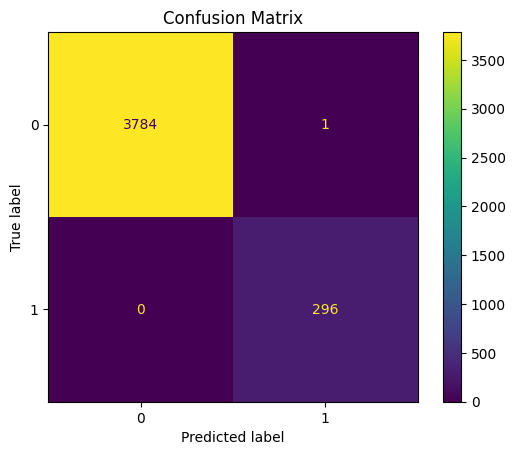

In [30]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Traditional Credit Scoring Using Logistic Regression
import scorecardpy as sc

# data prepare ------
# load germancredit data
dat = sc.germancredit()

# filter variable via missing rate, iv, identical value rate
dt_s = sc.var_filter(dat, y="creditability")

# breaking dt into train and test
train, test = sc.split_df(dt_s, 'creditability').values()

# woe binning ------
bins = sc.woebin(dt_s, y="creditability")
# sc.woebin_plot(bins)

# binning adjustment
# # adjust breaks interactively
# breaks_adj = sc.woebin_adj(dt_s, "creditability", bins) 
# # or specify breaks manually
breaks_adj = {
    'age.in.years': [26, 35, 40],
    'other.debtors.or.guarantors': ["none", "co-applicant%,%guarantor"]
}
bins_adj = sc.woebin(dt_s, y="creditability", breaks_list=breaks_adj)

# converting train and test into woe values
train_woe = sc.woebin_ply(train, bins_adj)
test_woe = sc.woebin_ply(test, bins_adj)

y_train = train_woe.loc[:,'creditability']
X_train = train_woe.loc[:,train_woe.columns != 'creditability']
y_test = test_woe.loc[:,'creditability']
X_test = test_woe.loc[:,train_woe.columns != 'creditability']

# logistic regression ------
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr.fit(X_train, y_train)
# lr.coef_
# lr.intercept_

# predicted proability
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

# performance ks & roc ------
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

# score ------
card = sc.scorecard(bins_adj, lr, X_train.columns)
# credit score
train_score = sc.scorecard_ply(train, card, print_step=0)
test_score = sc.scorecard_ply(test, card, print_step=0)

# psi
sc.perf_psi(
  score = {'train':train_score, 'test':test_score},
  label = {'train':y_train, 'test':y_test}
)

In [10]:
variable_names = list(transformed_applications.columns[1:-1]) # exclude id dan credit event
X = transformed_applications[variable_names]
y = transformed_applications["credit_event"].values

print("y shape: ", y.shape)
print("X shape:", X.shape)

y shape:  (20403,)
X shape: (20403, 42)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (14282, 42)
X_test:  (6121, 42)
y_train:  (14282,)
y_test:  (6121,)


In [12]:
estimator = LogisticRegression(random_state=777)

scorecard = Scorecard(estimator=estimator, scaling_method="min_max",
                      scaling_method_params={"min": 300, "max": 850})

param_grid = {
    "estimator__C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

scorecard_search = GridSearchCV(
    estimator=scorecard,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1
)

# model fitting
scorecard.fit(X_train, y_train)

TypeError: Scorecard.__init__() missing 1 required positional argument: 'binning_process'

In [25]:
estimator = LogisticRegression(random_state=777)

scorecard = Scorecard(binning_process=binning_process,
                      estimator=estimator, scaling_method="min_max",
                      scaling_method_params={"min": 300, "max": 850})

param_grid = {
    "estimator__C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

scorecard_search = GridSearchCV(
    estimator=scorecard,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1
)

# model fitting
scorecard.fit(X_train, y_train)

Scorecard(binning_process=BinningProcess(categorical_variables=['reg_city_not_work_city',
                                                                'flag_document_3'],
                                         variable_names=['amt_annuity',
                                                         'amt_goods_price',
                                                         'name_income_type',
                                                         'name_education_type',
                                                         'region_population_relative',
                                                         'days_employed',
                                                         'days_registration',
                                                         'days_id_publish',
                                                         'own_car_age',
                                                         'occupation_type',
                                                         'region_rating_client_w_city',
                                                         'reg_cit...
                                                         'entrances_medi',
                                                         'days_last_phone_change',
                                                         'flag_document_3',
                                                         'sk_id_prev_count',
                                                         'sk_dpd_def_max',
                                                         'amt_credit_sum_debt_sum',
                                                         'amt_credit_sum_limit_sum',
                                                         'amt_balance_avg_avg',
                                                         'amt_drawings_atm_current_avg_avg',
                                                         'amt_drawings_current_avg_avg', ...]),
          estimator=LogisticRegression(random_state=777),
          scaling_method='min_max',
          scaling_method_params={'max': 850, 'min': 300})

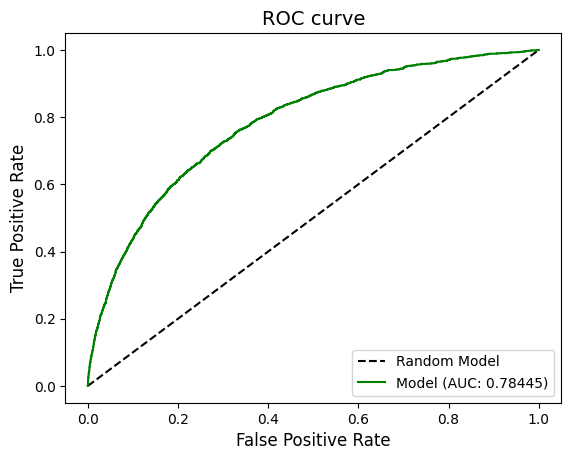

In [26]:
y_pred = scorecard.predict_proba(X_train)[:, 1]
plot_auc_roc(y_train, y_pred)

AttributeError: module 'matplotlib' has no attribute 'title'

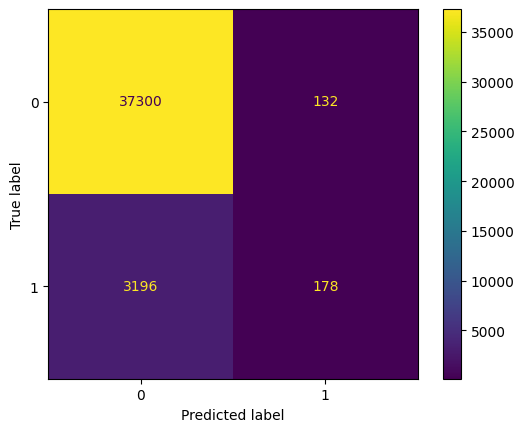

In [28]:
import matplotlib as plt
y_pred = scorecard.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [14]:
y_pred = estimator.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7499
           1       1.00      1.00      1.00       663

    accuracy                           1.00      8162
   macro avg       1.00      1.00      1.00      8162
weighted avg       1.00      1.00      1.00      8162



NameError: name 'plt' is not defined

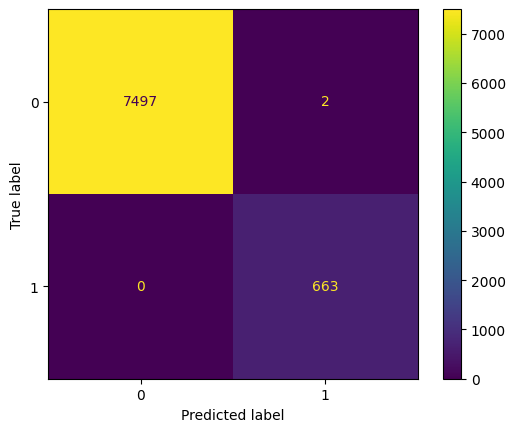

In [15]:
# Log the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()